Generative Adversarial Networks (GANs)
======================================
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder. If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [ ]:
import sys

In [ ]:
# install pytorch (http://pytorch.org/) and tqdm if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision #--index-url https://download.pytorch.org/whl/cu118  #uncomment to enforce cuda 11.8
if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm

%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

print(f"Using Pytorch {torch.__version__}.")

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

Parameter Settings
-------------------


In [ ]:
latent_dim = 100  # latent dimension
num_epochs = 50       # number of training epochs
batch_size = 512      # batch size (you may increase it to gain time, but check not to
                      # exceed your GPU memory limit)
learning_rate = 1e-3  # learning rate of the training algorithm
use_gpu = True        # use the GPU (strongly recommended for speed)
compile = False       # not well implemented on Colab (requires a personal installation with a
                      # relatively recent CUDA-compatible GPU)

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.ToTensor()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

mnist_dims = train_dataloader.dataset[0][0].shape[1:]
mnist_dim = train_dataloader.dataset[0][0].numel()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17754143.06it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 504692.10it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4547514.18it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8935520.06it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



Vanilla GAN
-----------
We define here the architecture of the different elements of the model. The init defines the different layers and the forward defines what happens when the model is called. We refer to it as the vanilla GAN as it the model in a very simple form.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, mnist_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))
        return x.view(-1, *mnist_dims)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(mnist_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

We can now instantiate and load the model onto the GPU if relevant.

In [ ]:
generator = Generator()
discriminator = Discriminator()

if compile:
  generator = torch.compile(generator)
  discriminator = torch.compile(discriminator)
  print("Using a compiled model (faster).")

if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))


Using the GPU (faster).
Number of parameters for generator: 1486352 and discriminator: 1460225


Training
--------
Be careful, the training can be relatively long, even with a GPU on Colab.

In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True):
        # moving the batch onto GPU if relevant
        image_batch = image_batch.to(device)

        # get dataset image and create real and fake labels for use in the loss
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dim, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print(f"\tAverage loss generator vs. discrim.: {gen_loss_avg[-1]:.3} vs. {disc_loss_avg[-1]:.3}")

print("Done.")

Training...


Epoch 1: 100%|██████████| 118/118 [00:18<00:00,  6.53it/s]


	Average loss generator vs. discrim.: 0.898 vs. 0.703


Epoch 2: 100%|██████████| 118/118 [00:09<00:00, 12.42it/s]


	Average loss generator vs. discrim.: 1.34 vs. 0.65


Epoch 3: 100%|██████████| 118/118 [00:08<00:00, 14.21it/s]


	Average loss generator vs. discrim.: 1.44 vs. 0.633


Epoch 4: 100%|██████████| 118/118 [00:08<00:00, 14.02it/s]


	Average loss generator vs. discrim.: 1.51 vs. 0.604


Epoch 5: 100%|██████████| 118/118 [00:07<00:00, 15.31it/s]


	Average loss generator vs. discrim.: 1.47 vs. 0.574


Epoch 6: 100%|██████████| 118/118 [00:08<00:00, 14.17it/s]


	Average loss generator vs. discrim.: 1.54 vs. 0.541


Epoch 7: 100%|██████████| 118/118 [00:08<00:00, 14.15it/s]


	Average loss generator vs. discrim.: 1.67 vs. 0.523


Epoch 8: 100%|██████████| 118/118 [00:07<00:00, 15.08it/s]


	Average loss generator vs. discrim.: 1.71 vs. 0.505


Epoch 9: 100%|██████████| 118/118 [00:08<00:00, 14.24it/s]


	Average loss generator vs. discrim.: 1.72 vs. 0.5


Epoch 10: 100%|██████████| 118/118 [00:08<00:00, 14.32it/s]


	Average loss generator vs. discrim.: 1.82 vs. 0.496


Epoch 11: 100%|██████████| 118/118 [00:07<00:00, 15.57it/s]


	Average loss generator vs. discrim.: 1.71 vs. 0.496


Epoch 12: 100%|██████████| 118/118 [00:08<00:00, 14.03it/s]


	Average loss generator vs. discrim.: 1.8 vs. 0.499


Epoch 13: 100%|██████████| 118/118 [00:08<00:00, 13.56it/s]


	Average loss generator vs. discrim.: 1.86 vs. 0.483


Epoch 14: 100%|██████████| 118/118 [00:08<00:00, 13.93it/s]


	Average loss generator vs. discrim.: 1.85 vs. 0.474


Epoch 15: 100%|██████████| 118/118 [00:08<00:00, 14.05it/s]


	Average loss generator vs. discrim.: 1.9 vs. 0.464


Epoch 16: 100%|██████████| 118/118 [00:08<00:00, 14.20it/s]


	Average loss generator vs. discrim.: 2.07 vs. 0.446


Epoch 17: 100%|██████████| 118/118 [00:07<00:00, 15.61it/s]


	Average loss generator vs. discrim.: 1.95 vs. 0.452


Epoch 18: 100%|██████████| 118/118 [00:08<00:00, 14.28it/s]


	Average loss generator vs. discrim.: 2.1 vs. 0.428


Epoch 19: 100%|██████████| 118/118 [00:08<00:00, 14.12it/s]


	Average loss generator vs. discrim.: 2.17 vs. 0.425


Epoch 20: 100%|██████████| 118/118 [00:07<00:00, 15.43it/s]


	Average loss generator vs. discrim.: 2.23 vs. 0.411


Epoch 21: 100%|██████████| 118/118 [00:08<00:00, 14.26it/s]


	Average loss generator vs. discrim.: 2.26 vs. 0.412


Epoch 22: 100%|██████████| 118/118 [00:08<00:00, 14.25it/s]


	Average loss generator vs. discrim.: 2.24 vs. 0.407


Epoch 23: 100%|██████████| 118/118 [00:07<00:00, 15.33it/s]


	Average loss generator vs. discrim.: 2.26 vs. 0.406


Epoch 24: 100%|██████████| 118/118 [00:08<00:00, 14.12it/s]


	Average loss generator vs. discrim.: 2.31 vs. 0.4


Epoch 25: 100%|██████████| 118/118 [00:08<00:00, 14.24it/s]


	Average loss generator vs. discrim.: 2.4 vs. 0.399


Epoch 26: 100%|██████████| 118/118 [00:07<00:00, 15.59it/s]


	Average loss generator vs. discrim.: 2.37 vs. 0.396


Epoch 27: 100%|██████████| 118/118 [00:08<00:00, 13.89it/s]


	Average loss generator vs. discrim.: 2.46 vs. 0.377


Epoch 28: 100%|██████████| 118/118 [00:08<00:00, 14.08it/s]


	Average loss generator vs. discrim.: 2.45 vs. 0.387


Epoch 29: 100%|██████████| 118/118 [00:07<00:00, 15.31it/s]


	Average loss generator vs. discrim.: 2.44 vs. 0.376


Epoch 30: 100%|██████████| 118/118 [00:08<00:00, 14.13it/s]


	Average loss generator vs. discrim.: 2.55 vs. 0.367


Epoch 31: 100%|██████████| 118/118 [00:08<00:00, 14.21it/s]


	Average loss generator vs. discrim.: 2.61 vs. 0.366


Epoch 32: 100%|██████████| 118/118 [00:07<00:00, 15.57it/s]


	Average loss generator vs. discrim.: 2.69 vs. 0.36


Epoch 33: 100%|██████████| 118/118 [00:08<00:00, 14.01it/s]


	Average loss generator vs. discrim.: 2.75 vs. 0.344


Epoch 34: 100%|██████████| 118/118 [00:08<00:00, 14.41it/s]


	Average loss generator vs. discrim.: 2.74 vs. 0.354


Epoch 35: 100%|██████████| 118/118 [00:07<00:00, 15.06it/s]


	Average loss generator vs. discrim.: 2.74 vs. 0.343


Epoch 36: 100%|██████████| 118/118 [00:08<00:00, 14.25it/s]


	Average loss generator vs. discrim.: 2.75 vs. 0.345


Epoch 37: 100%|██████████| 118/118 [00:07<00:00, 14.88it/s]


	Average loss generator vs. discrim.: 2.8 vs. 0.341


Epoch 38: 100%|██████████| 118/118 [00:07<00:00, 14.76it/s]


	Average loss generator vs. discrim.: 2.85 vs. 0.328


Epoch 39: 100%|██████████| 118/118 [00:08<00:00, 14.03it/s]


	Average loss generator vs. discrim.: 2.78 vs. 0.334


Epoch 40: 100%|██████████| 118/118 [00:07<00:00, 15.10it/s]


	Average loss generator vs. discrim.: 2.81 vs. 0.329


Epoch 41: 100%|██████████| 118/118 [00:08<00:00, 14.75it/s]


	Average loss generator vs. discrim.: 2.8 vs. 0.341


Epoch 42: 100%|██████████| 118/118 [00:08<00:00, 14.08it/s]


	Average loss generator vs. discrim.: 2.84 vs. 0.327


Epoch 43: 100%|██████████| 118/118 [00:07<00:00, 15.26it/s]


	Average loss generator vs. discrim.: 2.94 vs. 0.314


Epoch 44: 100%|██████████| 118/118 [00:08<00:00, 14.56it/s]


	Average loss generator vs. discrim.: 2.98 vs. 0.311


Epoch 45: 100%|██████████| 118/118 [00:08<00:00, 13.87it/s]


	Average loss generator vs. discrim.: 2.94 vs. 0.314


Epoch 46: 100%|██████████| 118/118 [00:07<00:00, 15.26it/s]


	Average loss generator vs. discrim.: 3.04 vs. 0.307


Epoch 47: 100%|██████████| 118/118 [00:08<00:00, 14.45it/s]


	Average loss generator vs. discrim.: 3.11 vs. 0.301


Epoch 48: 100%|██████████| 118/118 [00:08<00:00, 14.25it/s]


	Average loss generator vs. discrim.: 3.09 vs. 0.299


Epoch 49: 100%|██████████| 118/118 [00:07<00:00, 15.30it/s]


	Average loss generator vs. discrim.: 3.05 vs. 0.294


Epoch 50: 100%|██████████| 118/118 [00:08<00:00, 14.35it/s]

	Average loss generator vs. discrim.: 3.15 vs. 0.284
Done.


You may save the obtained weights after training.

In [ ]:
import os
if not os.path.exists('./pretrained'):
  os.mkdir('./pretrained')

torch.save(generator.state_dict(), './pretrained/my_vanilla_gan_generator.pth')
torch.save(discriminator.state_dict(), './pretrained/my_vanilla_gan_discriminator.pth')

If already saved, they can be loaded in the following way.

In [ ]:
# first load your model to generate instances of the generator and discriminator (but don't train it)
generator.load_state_dict(torch.load('./pretrained/my_vanilla_gan_generator.pth'))
discriminator.load_state_dict(torch.load('./pretrained/my_vanilla_gan_discriminator.pth'))

<All keys matched successfully>

Training Curves
---------------

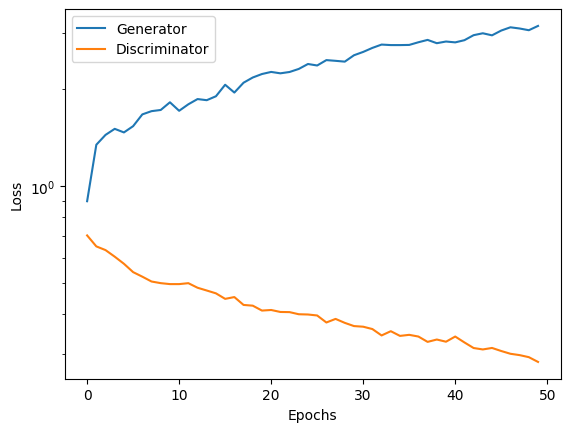

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.semilogy(gen_loss_avg, label='Generator')
plt.semilogy(disc_loss_avg, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Interpolate in Latent Space
----------------------------

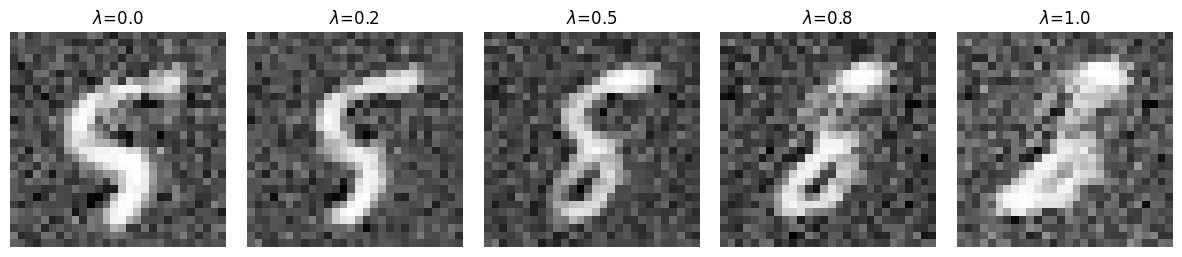

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dim, device=device)
latent_2 = torch.randn(1, latent_dim, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,:,:].squeeze(), cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

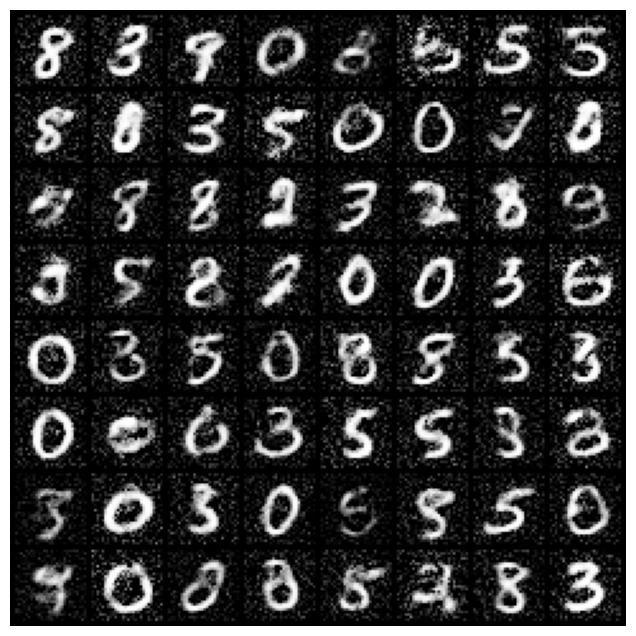

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn(n**2, latent_dim, device=device)
    fake_image_batch = generator(latent)
    if len(fake_image_batch.shape) == 3:
        fake_image_batch = fake_image_batch.unsqueeze(1)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

A CNN as Backbone
-----------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters. Running this will shadow the alternative vanilla version above. You will still need to instantiate it.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

Don't hesitate to tweak the architecture to improve it.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dim, latent_dim * 32, 5, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(latent_dim * 32)
        self.deconv2 = nn.ConvTranspose2d(latent_dim * 32, latent_dim * 16, 5, 1, 1)
        self.deconv2_bn = nn.BatchNorm2d(latent_dim * 16)
        self.deconv3 = nn.ConvTranspose2d(latent_dim * 16, latent_dim, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(latent_dim)
        self.deconv4 = nn.ConvTranspose2d(latent_dim, 1, 4, 2, 1)

    def forward(self, x):
        x = x[:, :, None, None]
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.sigmoid(self.deconv4(x))
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, latent_dim, 4, 2, 1)
        self.conv1_bn = nn.BatchNorm2d(latent_dim)
        self.conv2 = nn.Conv2d(latent_dim, latent_dim * 16, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(latent_dim * 16)
        self.conv3 = nn.Conv2d(latent_dim * 16, latent_dim * 32, 5, 1, 1)
        self.conv3_bn = nn.BatchNorm2d(latent_dim * 32)
        self.conv4 = nn.Conv2d(latent_dim * 32, latent_dim, 5, 1, 0)
        self.conv4_bn = nn.BatchNorm2d(latent_dim)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(latent_dim, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1_bn(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.fc(self.flatten(x)))
        return x

Again, you can save and load the trained weights.

In [ ]:
torch.save(generator.state_dict(), './pretrained/my_cnn_gan_generator.pth')
torch.save(discriminator.state_dict(), './pretrained/my_cnn_gan_discriminator.pth')

In [ ]:
generator.load_state_dict(torch.load('./pretrained/my_cnn_gan_generator.pth'))
discriminator.load_state_dict(torch.load('./pretrained/my_cnn_gan_discriminator.pth'))

<All keys matched successfully>

In [ ]:
generator = Generator()
discriminator = Discriminator()

if compile:
  generator = torch.compile(generator)
  discriminator = torch.compile(discriminator)
  print("Using a compiled model (faster).")

if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))


Using the GPU (faster).
Number of parameters for generator: 138576301 and discriminator: 138576701


In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True):
        # moving the batch onto GPU if relevant
        image_batch = image_batch.to(device)

        # get dataset image and create real and fake labels for use in the loss
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dim, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print(f"\tAverage loss generator vs. discrim.: {gen_loss_avg[-1]:.3} vs. {disc_loss_avg[-1]:.3}")

print("Done.")

Training...


Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1:   1%|          | 1/118 [00:07<13:49,  7.09s/it]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 4.77 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 13.22 GiB. GPU  (Triggered int

	Average loss generator vs. discrim.: 0.908 vs. 0.566


Epoch 2: 100%|██████████| 118/118 [32:40<00:00, 16.62s/it]


	Average loss generator vs. discrim.: 1.5 vs. 0.311


Epoch 3: 100%|██████████| 118/118 [32:43<00:00, 16.64s/it]


	Average loss generator vs. discrim.: 2.0 vs. 0.178


Epoch 4: 100%|██████████| 118/118 [32:43<00:00, 16.64s/it]


	Average loss generator vs. discrim.: 1.99 vs. 0.218


Epoch 5: 100%|██████████| 118/118 [32:45<00:00, 16.66s/it]


	Average loss generator vs. discrim.: 2.7 vs. 0.112


Epoch 6: 100%|██████████| 118/118 [32:45<00:00, 16.66s/it]


	Average loss generator vs. discrim.: 2.85 vs. 0.0697


Epoch 7: 100%|██████████| 118/118 [32:44<00:00, 16.65s/it]


	Average loss generator vs. discrim.: 3.14 vs. 0.0665


Epoch 8: 100%|██████████| 118/118 [32:44<00:00, 16.64s/it]


	Average loss generator vs. discrim.: 2.49 vs. 0.141


Epoch 9: 100%|██████████| 118/118 [32:44<00:00, 16.65s/it]


	Average loss generator vs. discrim.: 3.18 vs. 0.0472


Epoch 10:  16%|█▌        | 19/118 [05:19<27:45, 16.83s/it]

In [ ]:
import os
if not os.path.exists('./pretrained'):
  os.mkdir('./pretrained')

torch.save(generator.state_dict(), './pretrained/my_vanilla_gan_generator.pth')
torch.save(discriminator.state_dict(), './pretrained/my_vanilla_gan_discriminator.pth')

In [ ]:
# first load your model to generate instances of the generator and discriminator (but don't train it)
generator.load_state_dict(torch.load('./pretrained/my_vanilla_gan_generator.pth'))
discriminator.load_state_dict(torch.load('./pretrained/my_vanilla_gan_discriminator.pth'))

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.semilogy(gen_loss_avg, label='Generator')
plt.semilogy(disc_loss_avg, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn(n**2, latent_dim, device=device)
    fake_image_batch = generator(latent)
    if len(fake_image_batch.shape) == 3:
        fake_image_batch = fake_image_batch.unsqueeze(1)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

You can now have a look at the results of the model by running again the corresponding sections.